# DOWNLOAD LIBRARY

In [ ]:
import sys
import subprocess
import warnings

warnings.filterwarnings("ignore")

required_packages = {
    'joblib': '1.3.2',
    'loky': '3.4.0',
    'cloudpickle': '2.2.1'
}

for package, version in required_packages.items():
    try:
        subprocess.check_call([
            sys.executable,
            "-m",
            "pip",
            "install",
            f"{package}=={version}",
            "--quiet",
            "--disable-pip-version-check"
        ])
        print(f"✓ Successfully installed {package} {version}")
    except subprocess.CalledProcessError:
        print(f"⚠ Failed to install {package} {version}")

print("\n=== DEPENDENCIES FIXED ===\n")

✓ Successfully installed joblib 1.3.2
✓ Successfully installed loky 3.4.0
✓ Successfully installed cloudpickle 2.2.1

=== DEPENDENCIES FIXED ===



#IMPORT LIBRARY & LOADING DATA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import silhouette_score
import joblib

df = pd.read_csv('ecommerce_customer_data_large.csv')

# DATA INSPECTION

In [ ]:
print("=== DATA PROFILE ===")
print(f"Total Records: {len(df)}")
print(f"Churn Distribution:\n{df['Churn'].value_counts(normalize=True)}")
print("\nMissing Values:")
print(df.isnull().sum())

=== DATA PROFILE ===
Total Records: 250000
Churn Distribution:
Churn
0    0.79948
1    0.20052
Name: proportion, dtype: float64

Missing Values:
Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64


#DATA PREPROCESSING

## MISSING VALUES

In [ ]:
df['Returns'] = df['Returns'].fillna(0)

## CONVERT DATETIME & CALCULATE RFM

In [ ]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
snapshot_date = df['Purchase Date'].max() + pd.DateOffset(days=1)

rfm = df.groupby('Customer ID').agg(
    Recency=('Purchase Date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Customer ID', 'count'),
    Monetary=('Total Purchase Amount', 'sum')
).reset_index()

## ADDING ADDITIONAL FEATURES

In [ ]:
additional_features = df.groupby('Customer ID').agg(
    Avg_Product_Price=('Product Price', 'mean'),
    Return_Rate=('Returns', 'mean'),
    Preferred_Payment=('Payment Method', lambda x: x.mode()[0]),
    Favorite_Category=('Product Category', lambda x: x.mode()[0]),
    Age=('Customer Age', 'first'),
    Gender=('Gender', 'first'),
    Churn=('Churn', 'max')
).reset_index()

final_data = pd.merge(rfm, additional_features, on='Customer ID')

## ENHANCED FEATURE ENGINEERING

In [ ]:
final_data['Value_Ratio'] = final_data['Monetary'] / final_data['Frequency']
final_data['Activity_Gap'] = final_data['Recency'] - final_data['Frequency']

#ADVANCED EDA & VISUALIZATION

In [ ]:
plt.figure(figsize=(15,10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

##RFM ANALYSIS

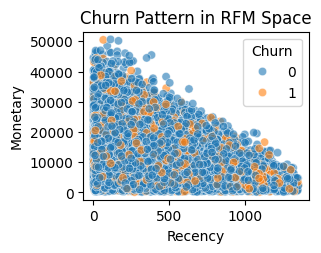

In [ ]:
plt.subplot(2,2,1)
sns.scatterplot(data=final_data, x='Recency', y='Monetary', hue='Churn', alpha=0.6)
plt.title('Churn Pattern in RFM Space')
plt.show()

##DEMOGRAPHIC ANALYSIS

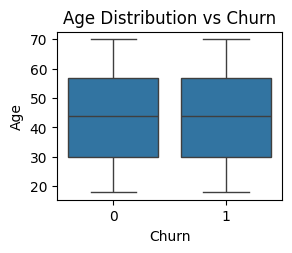

In [ ]:
plt.subplot(2,2,2)
sns.boxplot(data=final_data, x='Churn', y='Age')
plt.title('Age Distribution vs Churn')
plt.show()

## PAYMENT METHOD ANALYSIS

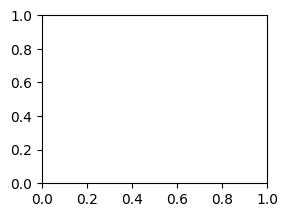

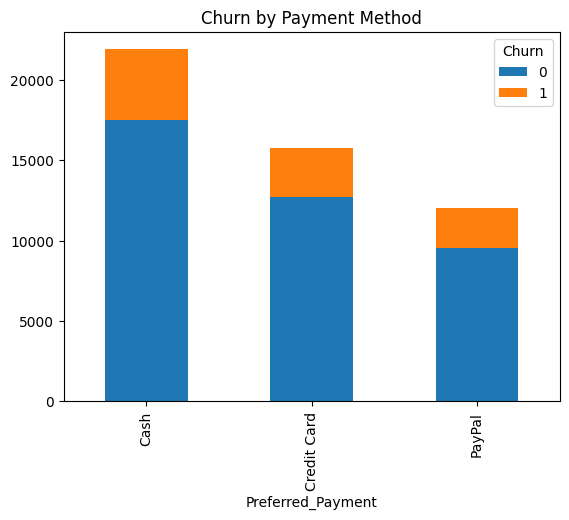

In [ ]:
plt.subplot(2,2,3)
payment_churn = pd.crosstab(final_data['Preferred_Payment'], final_data['Churn'])
payment_churn.plot(kind='bar', stacked=True)
plt.title('Churn by Payment Method')
plt.show()

#CHURN PREDICTION MODELING

##PREPARATION WITH ENHANCED FEATURES

In [ ]:
final_data = pd.get_dummies(final_data, columns=['Preferred_Payment', 'Favorite_Category', 'Gender'])
X = final_data.drop(['Customer ID', 'Churn'], axis=1)
y = final_data['Churn']

##OPTIMIZE TRAIN-TEST & ENHANCE PIPELINE WITH SMOTE AND PARAMETER TUNING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=4778,
    stratify=y
)

pipeline = imbpipeline([
    ('smote', SMOTE(random_state=4778)),
    ('classifier', RandomForestClassifier(
        class_weight='balanced_subsample',
        random_state=4778
    ))
])

params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5]
}

## GRID SEARCH WITH PARALLEL PROCESSING

In [ ]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 8 candidates, totalling 24 fits


#MODEL EVALUATION

In [ ]:
print("\n=== OPTIMIZED MODEL PERFORMANCE ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.3f}")


=== OPTIMIZED MODEL PERFORMANCE ===
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      7947
           1       0.18      0.01      0.02      1986

    accuracy                           0.79      9933
   macro avg       0.49      0.50      0.45      9933
weighted avg       0.68      0.79      0.71      9933

AUC Score: 0.506


##FEATURE IMPORTANCE VISUALIZATION

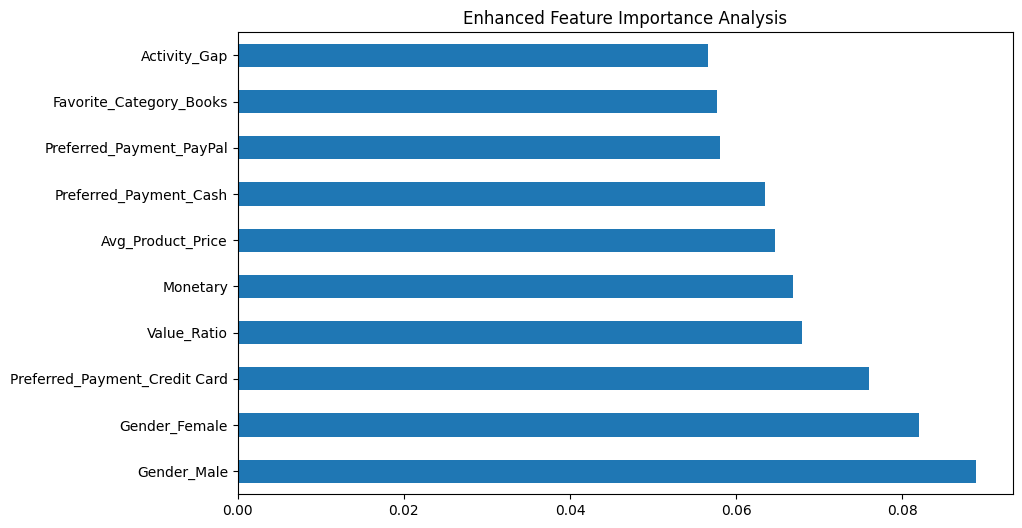

In [ ]:
feature_importance = pd.Series(
    best_model.named_steps['classifier'].feature_importances_,
    index=X.columns
)
plt.figure(figsize=(10,6))
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Enhanced Feature Importance Analysis')
plt.show()

#CUSTOMER SEGMENTATION

##ADVANCED CLUSTERING WITH VALIDATION

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##ELBOW-METHOD WITH SILHOUETTE VALIDATION

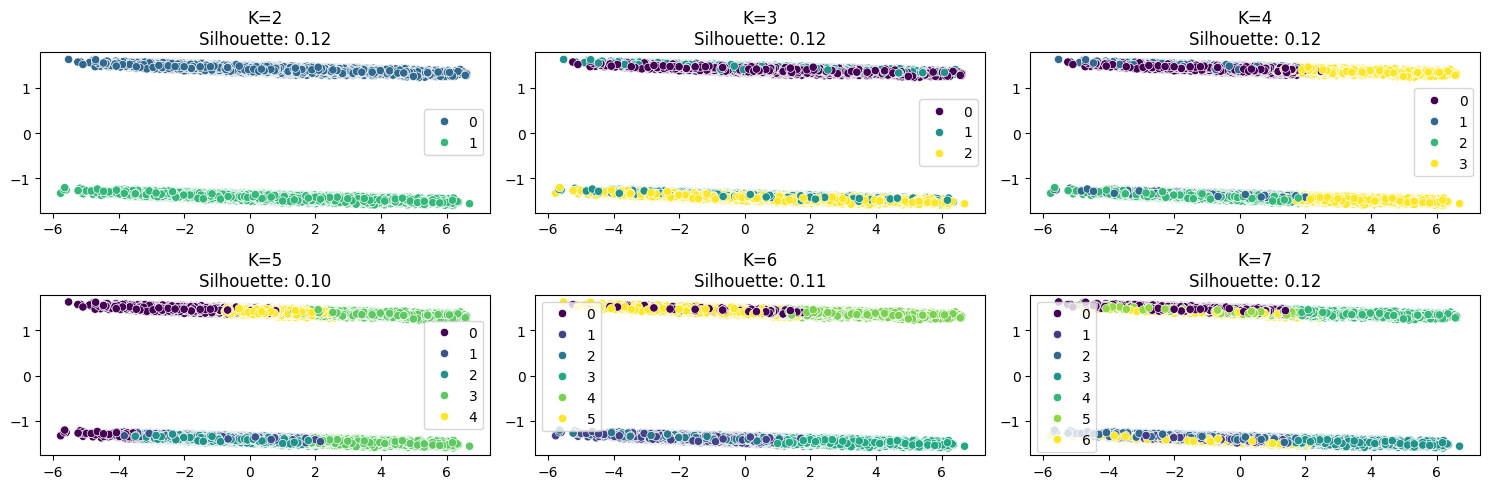

In [ ]:
k_values = range(2,8)
silhouette_scores = []

plt.figure(figsize=(15,5))
for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=4778)
    cluster_labels = kmeans.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    plt.subplot(2,3,i+1)
    pca = PCA(n_components=2).fit_transform(X_scaled)
    sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=cluster_labels, palette='viridis')
    plt.title(f'K={k}\nSilhouette: {silhouette_avg:.2f}')

plt.tight_layout()
plt.show()

##FINAL CLUSTERING WITH OPTIMAL K

In [ ]:
optimal_k = 5
final_kmeans = KMeans(n_clusters=optimal_k, random_state=4778)
clusters = final_kmeans.fit_predict(X_scaled)

#CLUSTER ANALYSIS & SAVING

In [ ]:
final_data['Cluster'] = clusters

joblib.dump(best_model, 'optimized_churn_model.pkl')
joblib.dump(final_kmeans, 'customer_segmentation_model.pkl')

cluster_report = final_data.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'Age': 'mean',
    'Return_Rate': 'mean',
    'Churn': 'mean'
}).reset_index()

print("\n=== ADVANCED CLUSTER ANALYSIS ===")
print(cluster_report)


=== ADVANCED CLUSTER ANALYSIS ===
  Cluster     Recency             Frequency                Monetary  \
                 mean         std      mean       std          mean   
0       0  150.862626  131.704807  7.223383  1.783562  21025.237132   
1       1  196.022612  156.448543  5.338185  2.100100  14582.340729   
2       2  187.063362  144.115577  5.296463  2.004344  14428.693159   
3       3  775.583210  198.478541  2.792673  1.339284   7501.512896   
4       4  220.096630  152.527698  4.073746  1.335593  10189.330016   

                      Age Return_Rate     Churn  
           std       mean        mean      mean  
0  5300.022123  45.439287    0.402457  0.203586  
1  6561.973431  43.888214    0.406732  0.191351  
2  6261.053642  43.832309    0.408997  0.200806  
3  4247.863922  43.832265    0.403330  0.205356  
4  3623.918276  42.658150    0.406442  0.198511  


#STRATEGIC VISUALIZATION

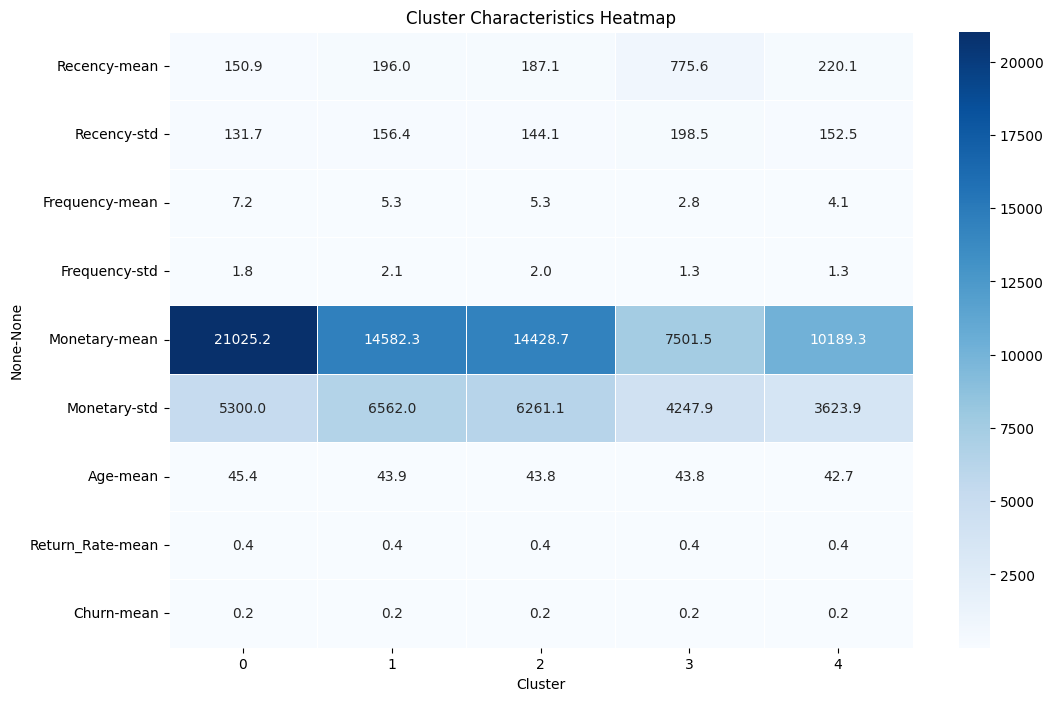

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(cluster_report.set_index('Cluster').T,
            annot=True,
            cmap='Blues',
            fmt=".1f",
            linewidths=.5)
plt.title('Cluster Characteristics Heatmap')
plt.show()